# SMAI Assignment - 2

## Question 1: Naive Bayes and Clustering

### Part 1: Naive Bayes

[Files](https://drive.google.com/drive/folders/1OUVrOMp2jSSBDJSqvEyXDFTrhiyZnqit?usp=sharing)

You will be performing Sentiment Analysis on a product review dataset with reviews from customers and star rating belonging to four classes (1,2,4,5). You can use sklearn for this question. Your tasks are as follows:

1.   Clean the text by removing punctations and preprocess them using techniques such as stop word removal, stemming etc. You can explore anything!
1.  Create BoW features using the word counts. You can choose the words that form the features such that the performance is optimised. Use the train-test split provided in `train_test_index.pickle` and report any interesting observations based on metrics such as accurarcy, precision, recall and f1 score (You can use Classification report in sklearn).
1. Repeat Task 2 with TfIdf features.

In [85]:
import pickle

In [86]:
with open('train_test_index.pickle', 'rb') as handle:
    train_test_index_dict = pickle.load(handle)

In [87]:
train_test_index_dict['train_index'][: 5]

[6914, 8332, 2791, 25106, 11135]

In [88]:
len(train_test_index_dict['train_index']) + len(train_test_index_dict['test_index'])

26661

In [89]:
import pandas as pd

data = pd.read_csv('product_reviews.csv')
data.head()

,text,stars,sentiment
0,Total bill for this horrible service? Over $8G...,1.0,0
1,Went in for a lunch. Steak sandwich was delici...,5.0,1
2,This place has gone down hill. Clearly they h...,1.0,0
3,"Walked in around 4 on a Friday afternoon, we s...",1.0,0
4,Michael from Red Carpet VIP is amazing ! I rea...,4.0,1


In [90]:
len(data)

26661

In [91]:
print(data['text'].iloc[1])

Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and distributed perfectly across each leaf. I know I'm going on about the salad ... But it was perfect.

Drink prices were pretty good.

The Server, Dawn, was friendly and accommodating. Very happy with her.

In summation, a great pub experience. Would go again!


#### Pre-process Review Texts
Stemming does not yield good results - it chops off the ends, often removing the derivational affixes. Utilizing lemmatization that uses linguistic knowledge, helps us derive relevant base words. 

In [92]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import spacy
import re
from multiprocessing import Pool, cpu_count

In [93]:
nlp = spacy.load('en_core_web_sm')

In [94]:
def preprocess_text(text):
    # tokenize the text into words
    tokens = word_tokenize(text.lower())
    
    # remove punctuations
    tokens = [token for token in tokens if token not in string.punctuation]
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatize
    lemmatized_tokens = [nlp(token)[0].lemma_ for token in tokens]

    # remove words that do not comprise an alphabet/digit
    pattern = r'[a-zA-Z0-9]'
    tokens = [token for token in lemmatized_tokens if re.search(pattern, token)]

    clean_text = ' '.join(tokens)
    return clean_text
    

In [95]:
def preprocess_chunk(chunk):
    chunk['clean_text'] = chunk['text'].apply(preprocess_text)
    return chunk

# Define number of processes to use (default to number of CPU cores)
num_processes = cpu_count()

# Split the data into chunks for parallel processing
chunk_size = int(np.ceil(len(data) / num_processes))
data_chunks = [data[i: i+chunk_size] for i in range(0, len(data), chunk_size)]

# Create a Pool of processes
with Pool(processes=num_processes) as pool:
    processed_chunks = pool.map(preprocess_chunk, data_chunks)

# Concatenate processed chunks back into a single DataFrame
data = pd.concat(processed_chunks, ignore_index=True)

In [96]:
data.tail()

,text,stars,sentiment,clean_text
26656,"Save your money, and don't go here.\nThis plac...",1.0,0,save money not go place stick go walk entire s...
26657,My husband and I thought we would give The Sus...,2.0,0,husband think would give sushi another try sto...
26658,"Petit café sympa, peu de place assise. Bonne b...",4.0,1,petit café sympa peu de place assise bonne bou...
26659,Absolutely delicious! The food was full of ama...,5.0,1,absolutely delicious food full amazing flavor ...
26660,Best place to be for sports events. Service an...,5.0,1,good place sport event service location amazin...


In [97]:
row = data.iloc[10]
print(row['text'])
print(row['clean_text'])

Pick any meat on the planet and the chef will make a Mexican style dish with amazing flavor! Wow, fish and lamb tacos to die for. Drinks are great as well.
pick meat planet chef make mexican style dish amazing flavor wow fish lamb tacos die drink great well


#### Perform Naive Bayes Classification

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [99]:
# create feature set and label vector
X = data['clean_text']
y = data['stars']

# train-test split
X_train = X.iloc[train_test_index_dict['train_index']]
X_test = X.iloc[train_test_index_dict['test_index']]
y_train = y.iloc[train_test_index_dict['train_index']]
y_test = y.iloc[train_test_index_dict['test_index']]

#### Using BoW Features

In [100]:
# create BoW
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

nb_classifier_bow = MultinomialNB()
nb_classifier_bow.fit(X_train_bow, y_train)

y_pred_bow = nb_classifier_bow.predict(X_test_bow)

print(classification_report(y_test, y_pred_bow, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.72      0.76      0.74      1149
         2.0       0.44      0.10      0.16       587
         4.0       0.46      0.51      0.48      1981
         5.0       0.79      0.82      0.81      5082

    accuracy                           0.70      8799
   macro avg       0.60      0.55      0.55      8799
weighted avg       0.68      0.70      0.68      8799



#### Using TF-IDF Features

In [101]:
# create TF-IDF features 
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

nb_classifier_tfidf = MultinomialNB()
nb_classifier_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = nb_classifier_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_tfidf, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.91      0.13      0.22      1149
         2.0       0.00      0.00      0.00       587
         4.0       0.45      0.01      0.03      1981
         5.0       0.59      1.00      0.74      5082

    accuracy                           0.60      8799
   macro avg       0.49      0.29      0.25      8799
weighted avg       0.56      0.60      0.46      8799



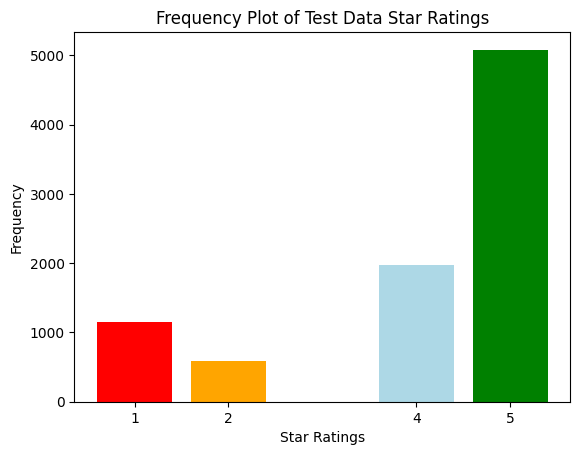

In [102]:
class_counts = {1.0: 0, 2.0: 0, 4.0: 0, 5.0: 0}
for rating in y_test:
    class_counts[rating] += 1

classes = list(class_counts.keys())
counts = list(class_counts.values())

# bar plot
plt.bar(classes, counts, color=['red', 'orange', 'lightblue', 'green'])
plt.xlabel('Star Ratings')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Test Data Star Ratings')
plt.xticks(classes) 
plt.show()

#### Observations:
- We see that the test accuracy with BoW features is 70% while with TF-IDF is 60%
- Since Naive Bayes treats the words same irrespective of their order and the relationship among them is ignored, it may exhibit high bias. This is the reason for not achieving very high accuracy while performing sentiment analysis. 

### Part 2: Clustering

You will be performing kmeans clustering on the same product reviews dataset from Part 1. In this question, instead of statistically computing features, you will use the embeddings obtained from a neural sentiment analysis model (huggingface: siebert/sentiment-roberta-large-english).

You can use sklearn for this question. Your tasks are as follows:


1. Perform kmeans clustering using sklearn. Try various values for number of clusters (k) and plot the elbow curve. For each value of k, plot WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.
1. Perform task 1 with cluster initialisation methods [k-means++, forgy ("random" in sklearn)].
1. In this case, since the ground truth labels (star rating) are available we can evaluate the clustering using metrics like purity, nmi and rand score. Implement these metrics from scratch and evaluate the clustering. [Reference](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)

In [103]:
import gzip
import numpy as np

f = gzip.GzipFile('roberta_embeds.npy.gz', "r")
embeds = np.load(f)
print(embeds.shape)

(26661, 1024)


In [104]:
embeds[0][: 10]

array([ 0.50699836,  0.61128891, -0.2719104 , -0.88892269, -0.64154392,
        0.67312002,  0.15486433, -0.8289389 ,  0.18982135, -0.98162079])

In [105]:
class_dict = {1.0: 0, 2.0: 1, 4.0: 2, 5.0: 3}

In [106]:
def get_contingency_matrix(classes, clusters):
    """
    classes: star ratings
    clusters: cluster indices
    Both lists are of same size
    """
    contingency_matrix = np.zeros((len(np.unique(classes)), len(np.unique(clusters))))
    for class_, cluster_ in zip(classes, clusters):
        contingency_matrix[class_dict[class_], cluster_] += 1
    return contingency_matrix

In [107]:
def purity_score(contingency_matrix, N):
    # sum of maximum counts in each cluster
    purity = np.sum(np.amax(contingency_matrix, axis=0)) / N
    return purity

In [108]:
def nmi_score(classes, clusters, contingency_matrix):
    # contingency_matrix = get_contingency_matrix(classes, clusters)
    
    mutual_information = 0
    N = len(classes)
    for k in range(len(np.unique(clusters))):
        for j in range(len(np.unique(classes))):
            if contingency_matrix[j][k] == 0:
                continue
                
            w_k = np.sum(contingency_matrix[:, k])
            c_j = np.sum(contingency_matrix[j, :])
            log_term = N * contingency_matrix[j][k]/ (w_k * c_j)
            mutual_information += contingency_matrix[j][k] * np.log2(log_term)
    mutual_information /= N

    entropy_cluster = 0
    for k in range(len(np.unique(clusters))):
        w_k = np.sum(contingency_matrix[:, k])
        entropy_cluster -= w_k * np.log2(w_k/ N)
    entropy_cluster /= N

    entropy_class = 0
    for j in range(len(np.unique(classes))):
        c_j = np.sum(contingency_matrix[j, :])
        entropy_class -= c_j * np.log2(c_j/ N)
    entropy_class /= N

    return 2 * mutual_information/ (entropy_class + entropy_cluster)

In [109]:
def rand_index_score(clusters, contingency_matrix):
    C = len(contingency_matrix)
    K = len(contingency_matrix[0])
    
    # compute true positive
    tp = 0
    tp_fp = 0
    for k in range(K):
        for j in range(C):
            x = contingency_matrix[j][k]
            if x >= 2:
                tp += x * (x-1)/ 2
        y = np.sum(contingency_matrix[:, k])
        tp_fp += y * (y-1)/ 2

    # compute false negative
    fn = 0
    for j in range(C):
        for k1 in range(K):
            for k2 in range(k1, K):
                fn += clusters[k1] * clusters[k2]
    
    tn_fn = 0
    for k1 in range(K):
        for k2 in range(k1, K):
            tn_fn += np.sum(contingency_matrix[:, k1]) * np.sum(contingency_matrix[:, k2])
    tn = tn_fn - fn
    
    return (tp + tn)/ (tp_fp + tn_fn) 

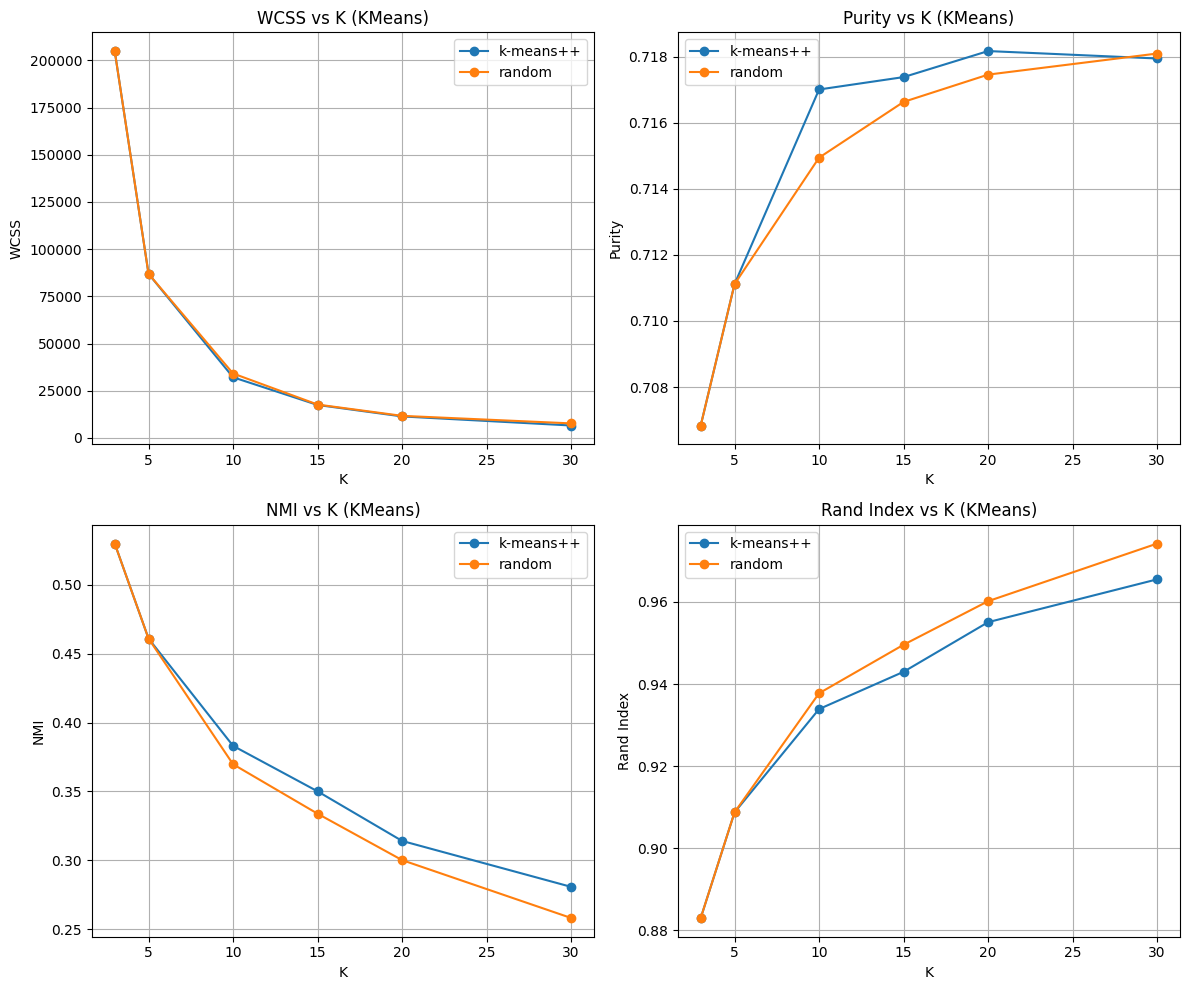

In [110]:
from sklearn.cluster import KMeans
 
k_values = [3, 5, 10, 15, 20, 30]
init_methods = ['k-means++', 'random']

rating_list = data['stars'].to_list()
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(len(init_methods)):
    wcss = []
    purity_list = []
    nmi_list = []
    randi_list = []
    
    for k in k_values: 
        kmeans = KMeans(n_clusters=k, random_state=42, init=init_methods[i], n_init=10)
        kmeans.fit(embeds)
        wcss.append(kmeans.inertia_)
        cluster_pred = kmeans.labels_ # same size as that of data['stars']

        # rows: stars (class), columns: cluster indices
        # each cell stores count
        contingency_matrix = get_contingency_matrix(rating_list, cluster_pred)
        
        purity = purity_score(contingency_matrix, len(rating_list))
        nmi = nmi_score(rating_list, cluster_pred, contingency_matrix)
        rand_index = rand_index_score(cluster_pred, contingency_matrix)
        
        purity_list.append(purity)
        nmi_list.append(nmi)
        randi_list.append(rand_index)
        
    axs[0, 0].plot(k_values, wcss, 'o-', label=init_methods[i])
    axs[0, 0].set_title(f'WCSS vs K (KMeans)')
    axs[0, 0].set_xlabel('K')
    axs[0, 0].set_ylabel('WCSS')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    axs[0, 1].plot(k_values, purity_list, 'o-', label=init_methods[i])
    axs[0, 1].set_title(f'Purity vs K (KMeans)')
    axs[0, 1].set_xlabel('K')
    axs[0, 1].set_ylabel('Purity')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    axs[1, 0].plot(k_values, nmi_list, 'o-', label=init_methods[i])
    axs[1, 0].set_title(f'NMI vs K (KMeans)')
    axs[1, 0].set_xlabel('K')
    axs[1, 0].set_ylabel('NMI')
    axs[1, 0].grid(True)
    axs[1, 0].legend()
    

    axs[1, 1].plot(k_values, randi_list, 'o-', label=init_methods[i])
    axs[1, 1].set_title(f'Rand Index vs K (KMeans)')
    axs[1, 1].set_xlabel('K')
    axs[1, 1].set_ylabel('Rand Index')
    axs[1, 1].grid(True)
    axs[1, 1].legend()
    
plt.tight_layout()
plt.show()